In [127]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint
import matplotlib.dates as mdates
import pandas as pd

data = pd.read_csv("sg_final.csv")

In [368]:
# get the data for the second outbreak (2020-06-01 to 2021-04-14)
data = data[data['Date'] < '2020-06-01']
data = data[data['Date'] > '2020-04-14']
i = data['Intensive Care Unit (ICU)'] + data['General Wards MOH report'] + data['In Isolation MOH report']
r = data['Cumulative Confirmed']- i - data['Cumulative Deaths']
d = data['Cumulative Deaths']
h = data['Intensive Care Unit (ICU)'] + data['General Wards MOH report']
l = i - h

# measure the influence of policy
mobile = (data['retail_and_recreation']+data['grocery_and_pharmacy']+data['residential']+data['transit_stations']+data['parks']+data['workplaces'])/6

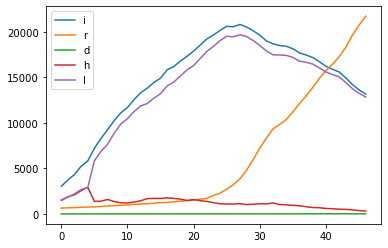

In [369]:
# plot datas for every states in SIR model
period = len(i)
t = np.arange(0, period)
plt.plot(t,i,label='i')
plt.plot(t,r,label='r')
plt.plot(t,d,label='d')
plt.plot(t,h,label='h')
plt.plot(t,l,label='l')
plt.legend()
plt.show()

In [402]:
# SIR differential model
def f(y, t, paras):
    """
    Your system of differential equations
    """

    s = y[0] 
    i = y[1]
    d = y[2]
    h = y[3]
    r = y[4]
    
    t1 = int(min(t + mobile.idxmin(), mobile.idxmax()))


    try:
        beta = paras['k0'].value
        gamma = paras['k1'].value
        p_h = paras['k2'].value
        r_d = paras['k3'].value
    except KeyError:
        beta, gamma,p_h,r_d = paras

    # the model equations
    s = max(0, s)
    s1 = -beta * s / 110000 * i * (1 + mobile[t1]/100) 
    i1 = -s1 - gamma * i - i * r_d
    d1 = i * r_d 
    h1 = i1 * p_h
    r1 = gamma * i 
    return [s1,i1,d1,h1,r1]

# ODE model
def g(t, x0, paras):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(f, x0, t, (paras,))
    return x

In [408]:
# residual function
def residual(paras, t, data):

    """
    compute the residual between actual data and fitted data
    """

    x0 = paras['s'].value, paras['i'].value, paras['d'].value, paras['h'].value, paras['r'].value
    model = g(t, x0, paras)
    return (model[:,p_index] - data[p_index - 1]).ravel()

def fit_i():
    plt.figure()
    t_t = data['Date']
    print(len(t_t))
    print(len(measured[0]))
    plt.scatter(t_t,measured[p_index - 1], marker='o', color='g', s=5, label = 'measured')
    result = minimize(residual, params, args=(t_x, measured), method='leastsq')  # leastsq nelder
    # check results of the fit
    data_fitted = g(t_x, x0, result.params)
    # plot measured data
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
    plt.xticks(rotation = 45)
    # plot fitted data
    plt.plot(t_t, data_fitted[:, p_index], '-', linewidth=2, color='red', label='fitted')
    report_fit(result)
    plt.legend()
    plt.savefig('before fit.jpg', bbox_inches = 'tight')
    return data_fitted

In [383]:
# set the initial parameters
indmin = i.index[0]
i0 = i[indmin]
d0 = d[indmin]
h0 = h[indmin]
r0 = r[indmin]
s0 = 90000

x0 = [s0,i0,d0,h0,r0]
t_x = np.arange(0, period)
measured = [i,d,h,r]

params = Parameters()
params.add('s', value=s0, vary=False)
params.add('i', value=i0, vary=False)
params.add('d', value=d0, vary=False)
params.add('h', value=h0, vary=False)
params.add('r', value=r0, vary=False)
params.add('k0', value=0.45, min=0.00001, max=0.5)
params.add('k1', value=0.1, min=0.00001, max=0.7)
params.add('k2', value = 8/100, min = 1/100, max = 0.2)
params.add('k3', value = 1/100, min = 0.001/100, max = 0.1)



47
47
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 47
    # variables        = 4
    chi-square         = 1.2801e+08
    reduced chi-square = 2977011.79
    Akaike info crit   = 704.421706
    Bayesian info crit = 711.822297
##  Warning: uncertainties could not be estimated:
    k2:  at initial value
[[Variables]]
    s:   90000 (fixed)
    i:   3040 (fixed)
    d:   10 (fixed)
    h:   1499 (fixed)
    r:   649 (fixed)
    k0:  0.44964359 (init = 0.45)
    k1:  0.08331551 (init = 0.1)
    k2:  0.08000000 (init = 0.08)
    k3:  0.01133790 (init = 0.01)


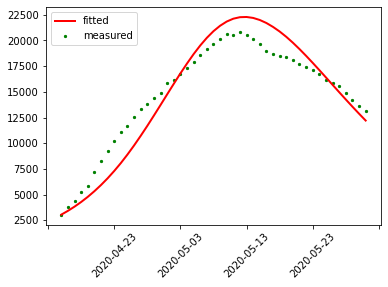

In [409]:
# fit I curve
p_index = 1
df = fit_i()

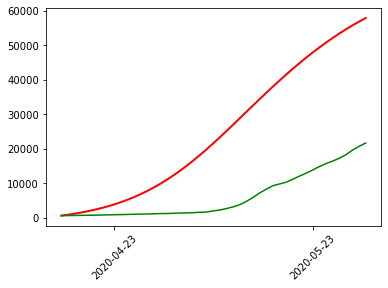

In [401]:
# plot R curve
t_t = data['Date']
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.xticks(rotation = 45)
plt.plot(t_t, df[:, 4], '-', linewidth=2, color='red', label='fitted')
plt.plot(t_t, measured[3],color = 'green',label = 'measured')

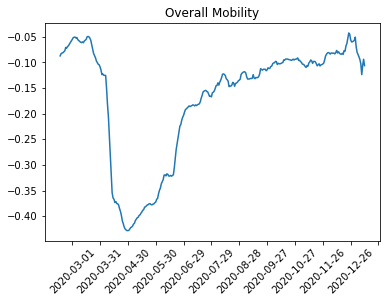

In [243]:
# plot the mobility
t_t = data['Date']
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.plot(t_t, mobile/100)
plt.xticks(rotation = 45)
plt.title('Overall Mobility')
plt.savefig('mobility before.jpg',bbox_inches = 'tight')